# Big Data & Data Lakehouse 2025 (A)

| Nama                     | NRP        |
| ------------------------ | ---------- |
| Hazwan Adhikara Nasution | 5027231017 |
| Rafael Gunawan           | 5027231019 |

**Dataset** :

🛍️ **Amazon UK Products Dataset 2023 (2.2M Products), Size (651,1 MB)**

**Description**
Amazon is one of the biggest online retailers in the UK. With this dataset, you can get an in-depth idea of what products sell best, which SEO titles generate the most sales, the best price range for a product in a given category, and much more.

link: https://www.kaggle.com/datasets/asaniczka/amazon-uk-products-dataset-2023/data?select=amz_uk_processed_data.csv


**Data Column:**

- **asin**
Product ID from Amazon. (type:str)

- **title**
Title of the product. (type:str)

- **imgUrl**
Url of the product image. (type:str)

- **productURL**
Url of the product. (type:str)

- **stars**
Product rating. If 0, no ratings were found. (type:float)

- **reviews**
Number of reviews. If 0, no reviews were found. (type:int)

- **price**
Buy now price of the product. If 0, price was unavailable. (type:float, currency: GBP)

- **isBestSeller**
Whether the product had the Amazon BestSeller status or not. (type:bool)

- **boughtInLastMonth**
Number of products sold last month according to Amazon. (type: int)

- **categoryName**
Name of the category this product belonged to



## Spark Session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Amazon UK Products Analysis 2023").getOrCreate()

25/05/09 05:07:00 WARN Utils: Your hostname, Zwanes-MacBook.local resolves to a loopback address: 127.0.0.1; using 192.168.110.23 instead (on interface en0)
25/05/09 05:07:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 05:07:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Preparation

In [2]:
from pyspark.sql.functions import col, sum, udf

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.feature import StringIndexer, VectorAssembler

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans

from pyspark.sql.types import StringType

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, ClusteringEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml import Pipeline

In [3]:
df = spark.read.csv("./amazondataset.csv", header=True, inferSchema=True)

df.printSchema()
df.show(5) 

row_count = df.count()
column_count = len(df.columns)
print(f"Rows: {row_count}, Columns: {column_count}")

root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- productURL: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- boughtInLastMonth: string (nullable = true)
 |-- categoryName: string (nullable = true)

+----------+--------------------+--------------------+--------------------+-----+-------+-----+------------+-----------------+--------------+
|      asin|               title|              imgUrl|          productURL|stars|reviews|price|isBestSeller|boughtInLastMonth|  categoryName|
+----------+--------------------+--------------------+--------------------+-----+-------+-----+------------+-----------------+--------------+
|B09B96TG33|Echo Dot (5th gen...|https://m.media-a...|https://www.amazo...|  4.7|  15308|21.99|       False|                0|Hi-Fi Speakers|
|B01HTH3C8S|Anker Sound

Rows: 2222742, Columns: 10


In [4]:
df.count() - df.dropDuplicates().count()

25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 05:07:20 WARN RowBasedKeyValueBatch: Calling spill() on

0

### Data Preprocessing

In [5]:
df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show()

+----+-----+------+----------+-----+-------+-----+------------+-----------------+------------+
|asin|title|imgUrl|productURL|stars|reviews|price|isBestSeller|boughtInLastMonth|categoryName|
+----+-----+------+----------+-----+-------+-----+------------+-----------------+------------+
|   0|    0|     0|         0|    0|      0|    0|           0|                0|          18|
+----+-----+------+----------+-----+-------+-----+------------+-----------------+------------+



In [6]:
df.filter(df["categoryName"].isNull()).show()

+----------+--------------------+--------------------+----------+-----+-------+-----+------------+--------------------+------------+
|      asin|               title|              imgUrl|productURL|stars|reviews|price|isBestSeller|   boughtInLastMonth|categoryName|
+----------+--------------------+--------------------+----------+-----+-------+-----+------------+--------------------+------------+
|B0B2J28MDF|"Helly-Hansen Men...|https://www.amazo...|       0.0|    0|   78.4|False|           0|   Sports & Outdoors|        NULL|
|B0C9BSXRR9|"Electric Bicycle...|https://www.amazo...|       0.0|    0| 682.99|False|           0|   Sports & Outdoors|        NULL|
|B0C972QXW7|"3 wheel bikes fo...|https://www.amazo...|       0.0|    0|1631.26|False|           0|   Sports & Outdoors|        NULL|
|B0C97234YM|"3 wheel bikes fo...|https://www.amazo...|       0.0|    0|1088.18|False|           0|   Sports & Outdoors|        NULL|
|B0C971N76S|"3 wheel bikes fo...|https://www.amazo...|       0.0|    

karena rows data ada 2juta++, sehingga 18 baris menurut kami tidak terlalu berpengaruh sehingga kami putuskan untuk drop saja rows yang mengandung null

In [7]:
df = df.filter(df["categoryName"].isNotNull())

In [8]:
df_clean = df.drop("asin", "title", "imgUrl", "productURL")

df_clean = df_clean.withColumn("stars", col("stars").cast("float")) \
                   .withColumn("reviews", col("reviews").cast("int")) \
                   .withColumn("price", col("price").cast("float")) \
                   .withColumn("boughtInLastMonth", col("boughtInLastMonth").cast("int")) \
                   .withColumn("isBestSeller", col("isBestSeller").cast("boolean"))

In [9]:
df_clean.show(5)
df_clean.dtypes

+-----+-------+-----+------------+-----------------+--------------+
|stars|reviews|price|isBestSeller|boughtInLastMonth|  categoryName|
+-----+-------+-----+------------+-----------------+--------------+
|  4.7|  15308|21.99|       false|                0|Hi-Fi Speakers|
|  4.7|  98099|23.99|        true|                0|Hi-Fi Speakers|
|  4.7|  15308|21.99|       false|                0|Hi-Fi Speakers|
|  4.7|   7205|31.99|       false|                0|Hi-Fi Speakers|
|  4.6|   1881|17.99|       false|                0|Hi-Fi Speakers|
+-----+-------+-----+------------+-----------------+--------------+
only showing top 5 rows



[('stars', 'float'),
 ('reviews', 'int'),
 ('price', 'float'),
 ('isBestSeller', 'boolean'),
 ('boughtInLastMonth', 'int'),
 ('categoryName', 'string')]

In [10]:
df_clean.select("categoryName").distinct().count()

3431

In [11]:
df_clean.groupBy("categoryName").count().orderBy("count", ascending=False).show(20)

+--------------------+------+
|        categoryName| count|
+--------------------+------+
|   Sports & Outdoors|821031|
|           Skin Care| 18752|
|          Fragrances| 18557|
|             Make-up| 18441|
|Manicure & Pedicu...| 17182|
|Handmade Clothing...| 16553|
|                 Men| 16334|
|               Women| 16273|
|      Handmade Gifts| 15702|
|    Handmade Artwork| 15135|
|         Bath & Body| 14863|
|Luggage and trave...| 14474|
|Handmade Kitchen ...| 14220|
|           Hair Care| 13532|
|  Handmade Jewellery| 12371|
|                Boys| 11779|
|                Baby| 10797|
|                   0| 10323|
|               Girls| 10018|
|Plants, Seeds & B...|  9445|
+--------------------+------+
only showing top 20 rows



In [12]:
top_10_categories = [
    "Sports & Outdoors",
    "Skin Care",
    "Fragrances",
    "Make-up",
    "Manicure & Pedicure",
    "Handmade Clothing, Shoes & Accessories",
    "Men",
    "Women",
    "Handmade Gifts",
    "Handmade Artwork"
]

df_top10 = df_clean.filter(col("categoryName").isin(top_10_categories))

convert ke pandas untuk memudahkan EDA

In [13]:
df_top10_pd = df_top10.toPandas()

## Exploratory Data Analysis

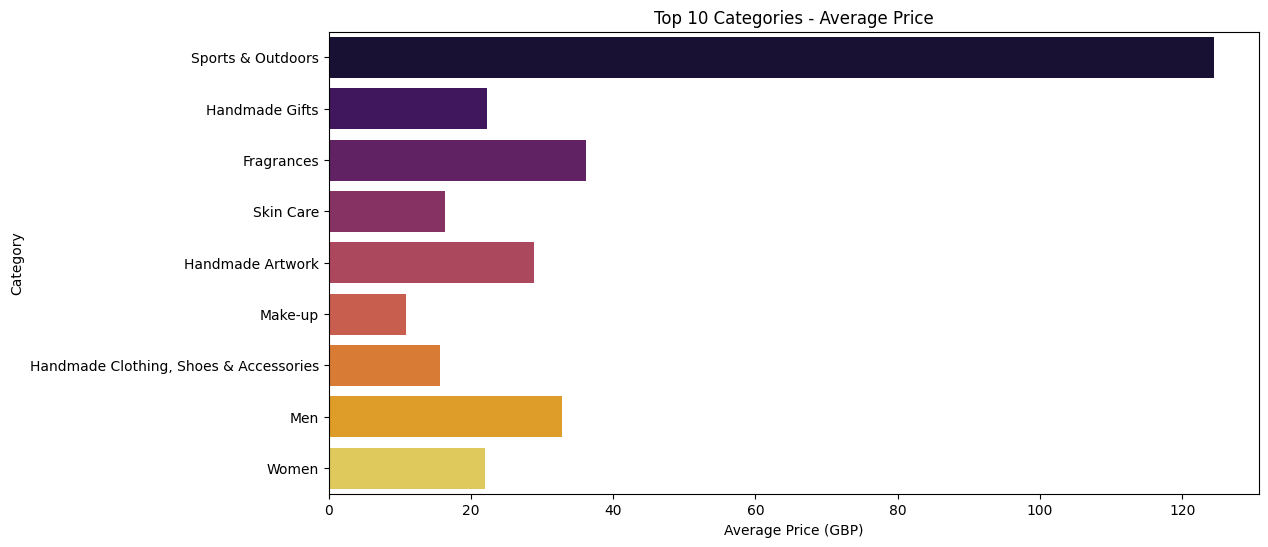

In [14]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_top10_pd, x="price", y="categoryName", hue="categoryName", errorbar=None, palette="inferno")
plt.title("Top 10 Categories - Average Price")
plt.xlabel("Average Price (GBP)")
plt.ylabel("Category")
plt.show()

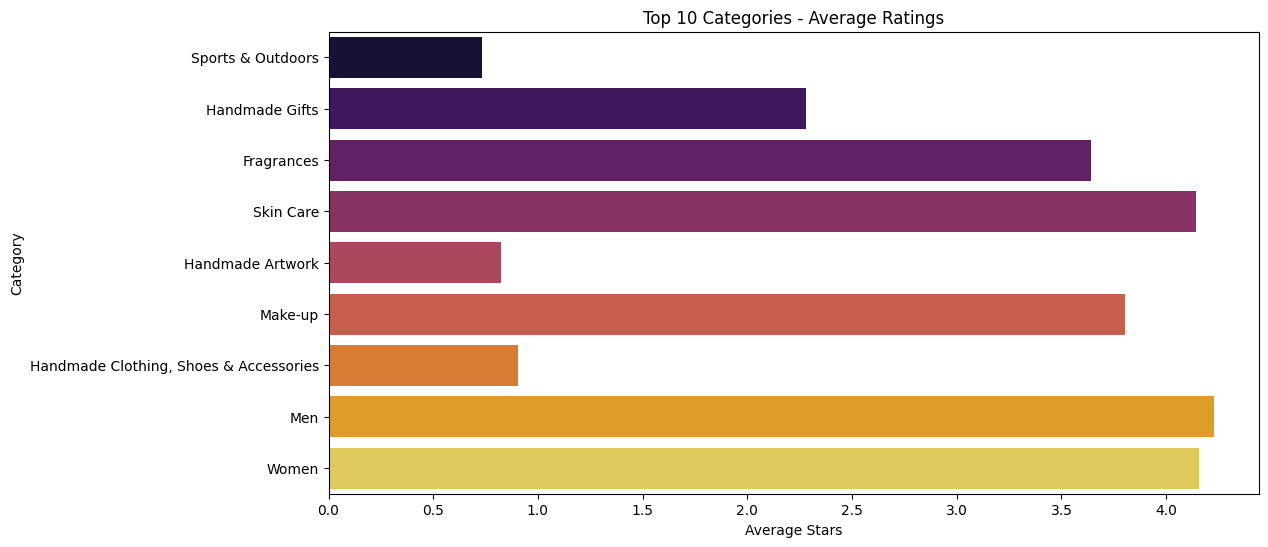

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_top10_pd, x="stars", y="categoryName", hue="categoryName", errorbar=None, palette="inferno")
plt.title("Top 10 Categories - Average Ratings")
plt.xlabel("Average Stars")
plt.ylabel("Category")
plt.show()

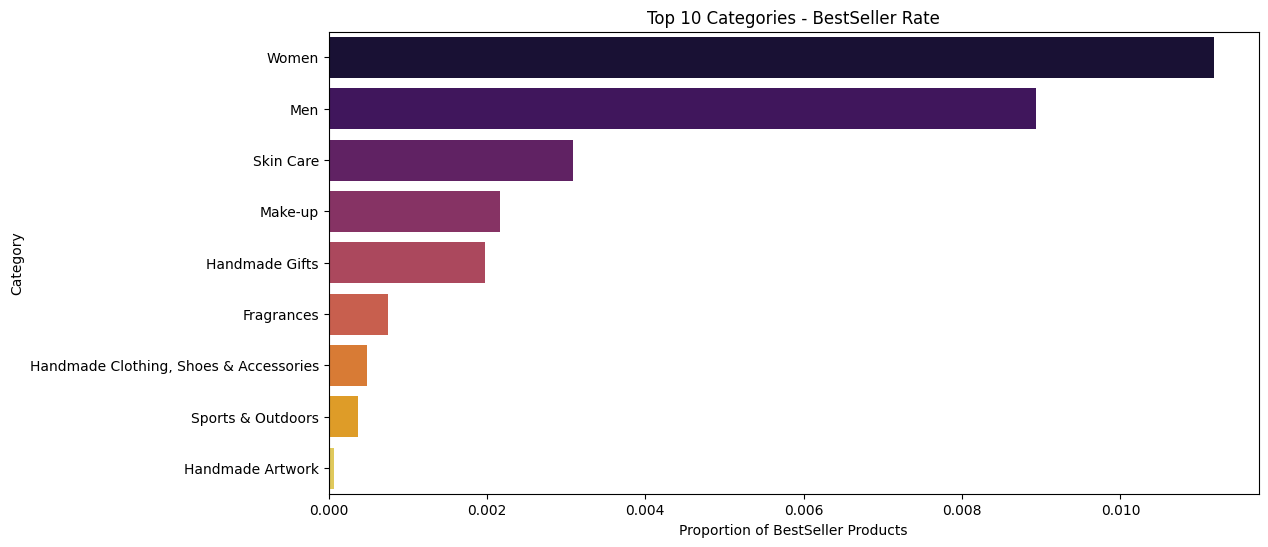

In [16]:
bestseller_rate = df_top10_pd.groupby("categoryName")["isBestSeller"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=bestseller_rate.values, y=bestseller_rate.index, hue=bestseller_rate.index, palette="inferno")
plt.title("Top 10 Categories - BestSeller Rate")
plt.xlabel("Proportion of BestSeller Products")
plt.ylabel("Category")
plt.show()

## 3 MLlib Algorithm (Classification, Regression, Clustering)

### Setup

In [17]:
df_top10_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956778 entries, 0 to 956777
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   stars              956778 non-null  float32
 1   reviews            956778 non-null  int32  
 2   price              956778 non-null  float32
 3   isBestSeller       956778 non-null  bool   
 4   boughtInLastMonth  956778 non-null  int32  
 5   categoryName       956778 non-null  object 
dtypes: bool(1), float32(2), int32(2), object(1)
memory usage: 22.8+ MB


### Classification (Decision Tree)

In [18]:
# Label Indexing
label_indexer = StringIndexer(inputCol="categoryName", outputCol="label")

# Assemble features
feature_cols = ["stars", "reviews", "price", "isBestSeller", "boughtInLastMonth"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Decision Tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Pipeline
classification_pipeline = Pipeline(stages=[label_indexer, assembler, dt])
classification_model = classification_pipeline.fit(df_top10)

# Get predictions
classification_predictions = classification_model.transform(df_top10)

label_model = classification_model.stages[0]
label_names = label_model.labels

def idx_to_category(idx):
    return label_names[int(idx)] if int(idx) < len(label_names) else "Unknown"

idx_to_category_udf = udf(idx_to_category, StringType())

classified_result = classification_predictions \
    .withColumn("label_category", idx_to_category_udf("label")) \
    .withColumn("prediction_category", idx_to_category_udf("prediction"))

classified_result.select("label_category", "prediction_category", "probability").show(30, truncate=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=49797) is multi-threaded, use of fork() may lead to deadlocks in the child.


+-----------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label_category   |prediction_category|probability                                                                                                                                                                              |
+-----------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sports & Outdoors|Sports & Outdoors  |[0.3316444035006909,0.1390142791340396,0.06374942422846615,0.23823122984799633,0.0235836020267158,0.04891754951635191,0.07664670658682635,0.06596038691847075,0.012252418240442193]      |
|Sports & Outdoors|Sports & Outdoors  |[0.5506737191614224,0.046484691710744756,0.08157986178139

"Sports & Outdoors",
    "Skin Care",
    "Fragrances",
    "Make-up",
    "Manicure & Pedicure",
    "Handmade Clothing, Shoes & Accessories",
    "Men",
    "Women",
    "Handmade Gifts",
    "Handmade Artwork"

### Regression (Linear Regression)

In [19]:
# Assemble features (exclude price from inputs)
regression_assembler = VectorAssembler(
    inputCols=["stars", "reviews", "isBestSeller", "boughtInLastMonth"],
    outputCol="features"
)

regression_data = regression_assembler.transform(df_top10).select("features", col("price").alias("label"))

# Train/test split
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)

# Linear Regression
lr = LinearRegression()
regression_model = lr.fit(regression_train)

# Predictions
regression_predictions = regression_model.transform(regression_test)

regression_predictions.select("label").describe().show()

25/05/09 05:08:22 WARN Instrumentation: [4d4c26b9] regParam is zero, which might cause numerical instability and overfitting.
25/05/09 05:08:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/09 05:08:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/05/09 05:08:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|            191344|
|   mean|111.23893250337917|
| stddev|424.41565607258286|
|    min|               0.0|
|    max|           21999.0|
+-------+------------------+



### Clustering (KMeans)

In [20]:
clustering_assembler = VectorAssembler(
    inputCols=["stars", "reviews", "price", "isBestSeller", "boughtInLastMonth"],
    outputCol="features"
)
clustering_data = clustering_assembler.transform(df_top10)

# KMeans model
kmeans = KMeans(k=3, seed=1)
clustering_model = kmeans.fit(clustering_data)

# Predict clusters
clustered_data = clustering_model.transform(clustering_data)

from pyspark.sql import functions as F
clustered_data.select("prediction", "categoryName") \
    .groupBy("prediction", "categoryName") \
    .count() \
    .orderBy(F.desc("count")) \
    .show()

+----------+--------------------+------+
|prediction|        categoryName| count|
+----------+--------------------+------+
|         0|   Sports & Outdoors|820384|
|         0|          Fragrances| 18413|
|         0|           Skin Care| 18264|
|         0|             Make-up| 18082|
|         0|Handmade Clothing...| 16553|
|         0|               Women| 15744|
|         0|      Handmade Gifts| 15702|
|         0|                 Men| 15649|
|         0|    Handmade Artwork| 15135|
|         1|                 Men|   633|
|         1|   Sports & Outdoors|   613|
|         1|               Women|   493|
|         1|           Skin Care|   447|
|         1|             Make-up|   329|
|         1|          Fragrances|   138|
|         2|                 Men|    52|
|         2|           Skin Care|    41|
|         2|               Women|    36|
|         2|   Sports & Outdoors|    34|
|         2|             Make-up|    30|
+----------+--------------------+------+
only showing top

"stars", "reviews", "price", "isBestSeller", "boughtInLastMonth"

In [21]:
centers = clustering_model.clusterCenters()
for idx, center in enumerate(centers):
    print(f"Cluster {idx} center: {center}")

Cluster 0 center: [1.05211987e+00 6.94052966e+01 1.10319857e+02 6.67766682e-04
 3.92944526e+00]
Cluster 1 center: [4.42570673e+00 1.46208059e+04 2.93284395e+01 4.74934037e-02
 2.80908406e+02]
Cluster 2 center: [4.45125627e+00 7.02036131e+04 2.46072362e+01 1.00502513e-01
 7.92462312e+02]


## Evaluation

### Classification

Classification Accuracy: 0.8629


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=49951) is multi-threaded, use of fork() may lead to deadlocks in the child.


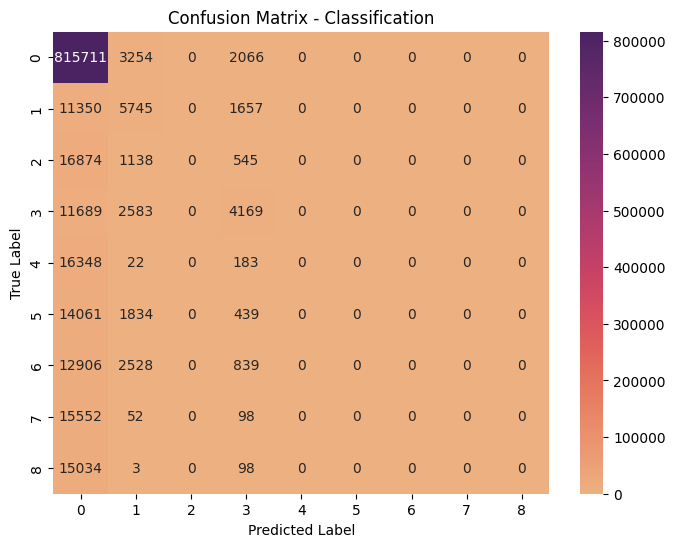

In [22]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(classification_predictions)
print(f"Classification Accuracy: {accuracy:.4f}")

# Confusion Matrix
preds_and_labels = classification_predictions.select("prediction", "label").rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(preds_and_labels)

# Confusion Matrix Visual
conf_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="flare")
plt.title("Confusion Matrix - Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Regression

Regression RMSE: 422.6401
Regression MAE: 147.2748
Regression R2: 0.0083


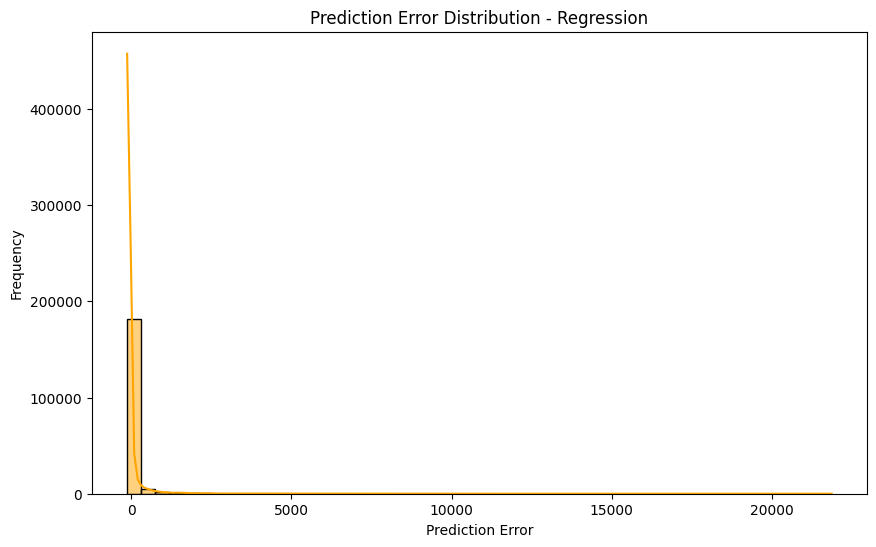

In [23]:
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(regression_predictions)
mae = evaluator_mae.evaluate(regression_predictions)
r2 = evaluator_r2.evaluate(regression_predictions)

print(f"Regression RMSE: {rmse:.4f}")
print(f"Regression MAE: {mae:.4f}")
print(f"Regression R2: {r2:.4f}")

# Convert to Pandas for visualizing error distribution
regression_pd = regression_predictions.select("label", "prediction").toPandas()
regression_pd["error"] = regression_pd["label"] - regression_pd["prediction"]

plt.figure(figsize=(10, 6))
sns.histplot(regression_pd["error"], bins=50, kde=True, color="orange")
plt.title("Prediction Error Distribution - Regression")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

### Clustering

Clustering Silhouette Score: 0.9950


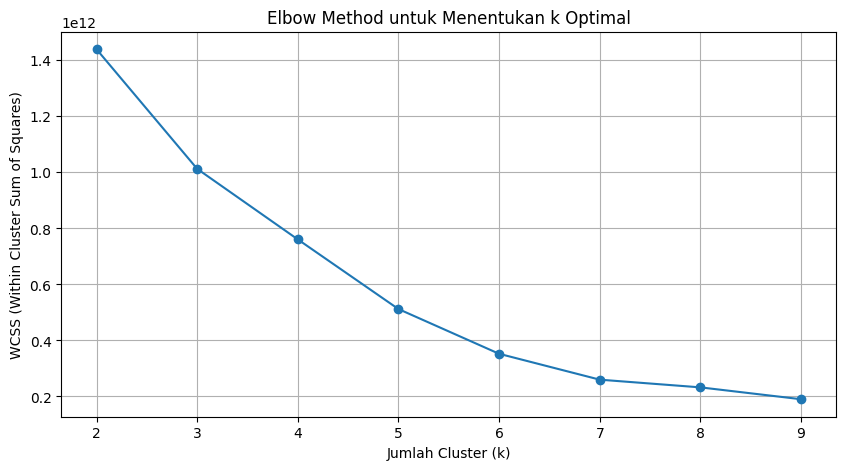

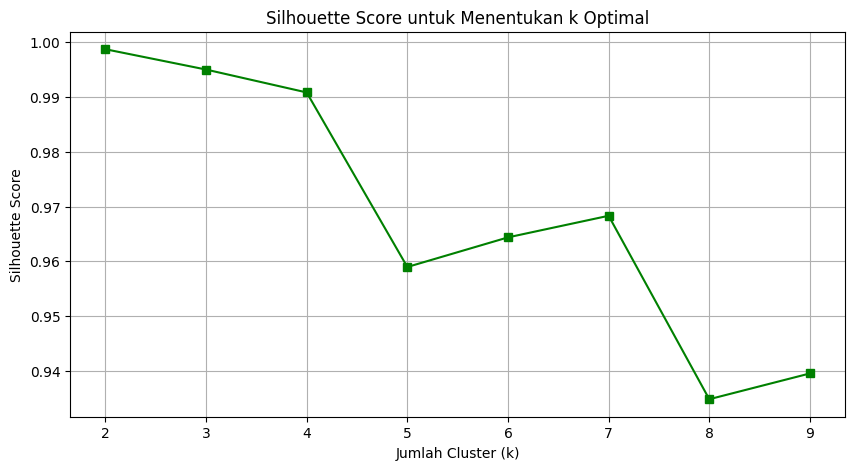

In [24]:
evaluator_silhouette = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator_silhouette.evaluate(clustered_data)

print(f"Clustering Silhouette Score: {silhouette:.4f}")

clustering_assembler = VectorAssembler(
    inputCols=["stars", "reviews", "price", "isBestSeller", "boughtInLastMonth"],
    outputCol="features"
)
clustering_data = clustering_assembler.transform(df_top10)

wcss = []
silhouette_scores = []

K = range(2, 10)

for k in K:
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(clustering_data)
    predictions = model.transform(clustering_data)

    # WCSS
    wcss.append(model.summary.trainingCost)

    # Silhouette Score
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette2 = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette2)

# Plot Elbow Method (WCSS)
plt.figure(figsize=(10,5))
plt.plot(K, wcss, marker='o')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.grid(True)
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10,5))
plt.plot(K, silhouette_scores, marker='s', color='green')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Menentukan k Optimal')
plt.grid(True)
plt.show()

In [25]:
print("\n=== Algorithm Comparison ===")
print(f"Classification Accuracy      : {accuracy:.4f}")
print(f"Regression RMSE              : {rmse:.4f}")
print(f"Regression MAE               : {mae:.4f}")
print(f"Regression R2                : {r2:.4f}")
print(f"Clustering Silhouette Score  : {silhouette:.4f}")


=== Algorithm Comparison ===
Classification Accuracy      : 0.8629
Regression RMSE              : 422.6401
Regression MAE               : 147.2748
Regression R2                : 0.0083
Clustering Silhouette Score  : 0.9950
